# Baseline Model

**Table of Contents**
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


### Model Choice
A Convolutional Neural Network (CNN) is an ideal baseline model for classifying 50 types of phytoplankton images, as it excels in capturing the subtle variances in shape, size, and texture that are crucial for distinguishing between different phytoplankton types. With its robustness to image variations and effectiveness in complex multi-class tasks, a CNN is highly suitable for this purpose. Moreover, its scalability and the potential for transfer learning add to its practicality in handling diverse datasets. Importantly, a CNN serves as an excellent starting point for model optimization, where further improvements can be achieved by fine-tuning hyperparameters and experimenting with various preprocessing techniques, allowing for tailored enhancements to suit specific dataset characteristics.

In [142]:
from google.colab import files, drive
import zipfile
import shutil
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Activation, Flatten, MaxPooling2D, Conv2D
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2
from collections import Counter
import random


In [131]:
drive.mount('/content/drive')

# Path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/ML_Tensorflow/phytoplankton_labeled.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

data_dir = '/content/dataset/labeled_20201020'

base_dir = '/content/dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
def prepare_data_for_class_range(class_range, class_to_idx):
    # Filter the paths and labels for the selected classes
    start_class, end_class = class_range
    filtered_image_paths = [path for path, label in zip(image_paths, labels) if class_to_idx[label] in range(start_class, end_class + 1)]
    filtered_labels = [label for label in labels if class_to_idx[label] in range(start_class, end_class + 1)]

    # Split the filtered dataset into train, val, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(filtered_image_paths, filtered_labels, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

    # Define directories for train, val, test
    train_dir = os.path.join(base_dir, f'train_directory_{start_class}_{end_class}')
    val_dir = os.path.join(base_dir, f'val_directory_{start_class}_{end_class}')
    test_dir = os.path.join(base_dir, f'test_directory_{start_class}_{end_class}')

    # Remove existing directories and recreate them
    for dir in [train_dir, val_dir, test_dir]:
        if os.path.exists(dir):
            shutil.rmtree(dir)
        os.makedirs(dir)

    # Function to create directories and copy images
    def create_and_copy(image_paths, labels, target_dir):
        for img_path, label in zip(image_paths, labels):
            class_dir = os.path.join(target_dir, label)
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)
            shutil.copy(img_path, os.path.join(class_dir, os.path.basename(img_path)))

    # Copy files to their respective directories
    create_and_copy(X_train, y_train, train_dir)
    create_and_copy(X_val, y_val, val_dir)
    create_and_copy(X_test, y_test, test_dir)

    return train_dir, val_dir, test_dir

# Specify the number of classes to include
num_classes = 10
batch_size = 32
epochs = 20

# Get paths and labels for a subset of classes
image_paths = []
labels = []
for class_dir in sorted(os.listdir(data_dir)):
    class_dir_path = os.path.join(data_dir, class_dir)
    if os.path.isdir(class_dir_path):
        image_paths.extend([os.path.join(class_dir_path, image) for image in os.listdir(class_dir_path)])
        labels.extend([class_dir] * len(os.listdir(class_dir_path)))

# Select the first 'num_classes' classes
unique_classes = np.unique(labels)
selected_classes = set(unique_classes[:num_classes])

# Generate a dictionary mapping numerical values to class names
class_to_idx = {class_name: idx for idx, class_name in enumerate(unique_classes)}

# Generate a dictionary mapping numerical values back to class names
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}

# Define the class range
class_ranges = [(0, 9), (10, 19), (20, 29), (30, 39), (40, 49)]

# Print completion message
for class_range in class_ranges:
    train_dir, val_dir, test_dir = prepare_data_for_class_range(class_range, class_to_idx)
    print(f"Data for classes {class_range} prepared and stored in:\nTrain: {train_dir}\nVal: {val_dir}\nTest: {test_dir}")


Data for classes (0, 9) prepared and stored in:
Train: /content/dataset/train_directory_0_9
Val: /content/dataset/val_directory_0_9
Test: /content/dataset/test_directory_0_9
Data for classes (10, 19) prepared and stored in:
Train: /content/dataset/train_directory_10_19
Val: /content/dataset/val_directory_10_19
Test: /content/dataset/test_directory_10_19
Data for classes (20, 29) prepared and stored in:
Train: /content/dataset/train_directory_20_29
Val: /content/dataset/val_directory_20_29
Test: /content/dataset/test_directory_20_29
Data for classes (30, 39) prepared and stored in:
Train: /content/dataset/train_directory_30_39
Val: /content/dataset/val_directory_30_39
Test: /content/dataset/test_directory_30_39
Data for classes (40, 49) prepared and stored in:
Train: /content/dataset/train_directory_40_49
Val: /content/dataset/val_directory_40_49
Test: /content/dataset/test_directory_40_49


In [139]:
# Undersampling overrepresented classes
desired_count = 1000

def undersample_training_directories(class_ranges):
    class_counts = {}

    for class_range in class_ranges:
        train_dir = os.path.join(base_dir, f'train_directory_{class_range[0]}_{class_range[1]}')

        for class_dir in os.listdir(train_dir):
            class_dir_path = os.path.join(train_dir, class_dir)
            if os.path.isdir(class_dir_path):
                images = os.listdir(class_dir_path)
                if len(images) > desired_count:
                    # Randomly select and remove images
                    images_to_remove = random.sample(images, len(images) - desired_count)
                    for image in images_to_remove:
                        os.remove(os.path.join(class_dir_path, image))

                # Update class_counts dictionary
                class_counts[class_dir] = len(os.listdir(class_dir_path))

    return class_counts

class_counts = undersample_training_directories(class_ranges)
print(class_counts)

{'Aphanothece_paralleliformis': 19, 'Chlorococcales': 68, 'Centrales_sp': 332, 'Chaetoceros_sp_single': 148, 'Aphanizomenon_flosaquae': 1000, 'Ceratoneis_closterium': 29, 'Beads': 92, 'Amylax_triacantha': 12, 'Chroococcales': 92, 'Chaetoceros_sp': 995, 'Cryptophyceae-Teleaulax': 1000, 'Ciliata': 177, 'Cyclotella_choctawhatcheeana': 73, 'Chroococcus_small': 590, 'Cryptomonadales': 500, 'Dolichospermum-Anabaenopsis-coiled': 1000, 'Dinophyceae': 991, 'Dolichospermum-Anabaenopsis': 1000, 'Dinophysis_acuminata': 150, 'Cymbomonas_tetramitiformis': 140, 'Gymnodinium_like': 112, 'Gonyaulax_verior': 19, 'Gymnodiniales': 49, 'Eutreptiella_sp': 1000, 'Heterocapsa_rotundata': 427, 'Katablepharis_remigera': 40, 'Heterocyte': 182, 'Heterocapsa_triquetra': 1000, 'Euglenophyceae': 64, 'Licmophora_sp': 50, 'Merismopedia_sp': 62, 'Pennales_sp_thick': 142, 'Monoraphidium_contortum': 214, 'Nitzschia_paleacea': 46, 'Mesodinium_rubrum': 782, 'Oscillatoriales': 1000, 'Melosira_arctica': 30, 'Nodularia_spumig

### Feature Selection

In the context of using a Convolutional Neural Network (CNN) for classifying images of phytoplankton, "feature selection" takes on a different meaning compared to traditional machine learning models. Unlike models where you manually select features from a dataset, CNNs handle feature extraction and selection internally through their layers.

In [ ]:
def create_model(num_classes):
    # Load MobileNetV2 pre-trained on ImageNet data
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
    base_model.trainable = False  # Freeze the base model

    # Add custom layers on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')  # Output layer with 'num_classes' units
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to return augmented data generator for underrepresented classes
def get_augmentation():
    return ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.5,
        height_shift_range=0.5,
        shear_range=0.5,
        zoom_range=0.5,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

# Define a custom generator
def custom_generator(train_dir, batch_size, class_counts, desired_count):
    base_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir,
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode='categorical'
    )
    while True:
        x_batch, y_batch = next(base_generator)
        for i in range(x_batch.shape[0]):
            class_index = np.argmax(y_batch[i])
            class_name = list(base_generator.class_indices.keys())[class_index]
            if class_counts[class_name] < desired_count:
                aug_gen = get_augmentation()
                x_batch[i] = aug_gen.random_transform(x_batch[i])
        yield x_batch, y_batch

def create_data_generators(train_dir, val_dir, test_dir, batch_size, class_counts, desired_count):
    train_generator = custom_generator(train_dir, batch_size, class_counts, desired_count)

    val_datagen = ImageDataGenerator(rescale=1./255)
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, val_generator, test_generator

# Function to plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

for class_range in class_ranges:
    train_dir = f'/content/dataset/train_directory_{class_range[0]}_{class_range[1]}'
    val_dir = f'/content/dataset/val_directory_{class_range[0]}_{class_range[1]}'
    test_dir = f'/content/dataset/test_directory_{class_range[0]}_{class_range[1]}'

    # Create data generators
    train_generator, val_generator, test_generator = create_data_generators(
        train_dir, val_dir, test_dir, batch_size, class_counts, desired_count
    )

    # Create a new model for the current subset of classes
    num_classes = class_range[1] - class_range[0] + 1
    model = create_model(num_classes)
    model.summary()

    # Calculate the number of training samples for the current class range
    current_range_counts = {k: v for k, v in class_counts.items() if class_to_idx[k] in range(class_range[0], class_range[1] + 1)}
    num_train_samples = sum(current_range_counts.values())

    # Calculate steps per epoch for the current class range
    steps_per_epoch = np.ceil(num_train_samples / batch_size)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batch_size)
    )

    # Plot the training history
    plot_training_history(history)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy for classes {class_range}: {test_accuracy}")

    # Save the model for future use
    model.save(f'/content/drive/MyDrive/ML_Tensorflow/model_{class_range[0]}_{class_range[1]}.h5')

### Implementation

This CNN model, with its multiple convolutional and pooling layers followed by fully connected layers, is designed to effectively capture the hierarchical features in the phytoplankton images, making it suitable for the classification task at hand. The use of ReLU and softmax activations, along with the adam optimizer and categorical crossentropy loss, aligns well with the needs of a complex image classification challenge.

### Evaluation

1. Accuracy: This metric gives you a straightforward indication of the overall correctness of the model by showing the proportion of correct predictions out of all predictions. It's a useful initial indicator to see how well the model performs across all classes.

2. Confusion Matrix: This tool is particularly valuable in multi-class classification problems like your 50 phytoplankton types. It not only shows the overall performance but also breaks it down into each class, revealing how the model confuses between different types of phytoplankton. It can highlight if the model is particularly good or bad at classifying certain classes, which is critical information for fine-tuning.

In [144]:
def create_test_generator(test_dir, batch_size):
    test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale the pixel values

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(160, 160),  # Size of your input images, match with your model's input
        batch_size=batch_size,
        class_mode='categorical',  # Use 'binary' for binary classification
        shuffle=False  # Important to keep data in same order as labels
    )

    return test_generator

for class_range in class_ranges:
    model_dir = f'/content/drive/MyDrive/ML_Tensorflow/model_{class_range[0]}_{class_range[1]}.h5'
    model = load_model(model_dir)

    # Ensure your test_generator is set correctly for the current model
    test_dir = f'/content/dataset/test_directory_{class_range[0]}_{class_range[1]}'
    test_generator = create_test_generator(test_dir, batch_size)

    test_generator.shuffle = False
    test_generator.reset()

    # Predict using the model
    predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

    # Convert predictions to class indices
    predicted_class_indices = np.argmax(predictions, axis=1)

    # Get true labels from the generator
    true_labels = test_generator.classes

    # Calculate accuracy
    accuracy = np.sum(predicted_class_indices == true_labels) / len(true_labels)
    print(f"Accuracy for classes {class_range}: {accuracy}")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
    print(f"Confusion Matrix for classes {class_range}:\n{conf_matrix}")

    # Optional: Print classification report
    print(classification_report(true_labels, predicted_class_indices, target_names=test_generator.class_indices.keys()))

Found 952 images belonging to 10 classes.
30/30 [==============================] - 81s 636ms/step
Accuracy for classes (0, 9): 0.9810924369747899
Confusion Matrix for classes (0, 9):
[[  1   0   0   0   0   0   0   0   0   0]
 [  0 692   0   0   0   0   2   0   0   0]
 [  0   0   5   0   0   0   0   0   0   2]
 [  0   0   0  14   0   0   0   0   0   0]
 [  0   0   0   0  46   0   0   0   3   0]
 [  0   1   0   0   0   5   0   0   0   0]
 [  0   6   0   0   1   0 126   0   3   0]
 [  0   0   0   0   0   0   0  18   0   0]
 [  0   0   0   0   0   0   0   0  11   0]
 [  0   0   0   0   0   0   0   0   0  16]]
                             precision    recall  f1-score   support

          Amylax_triacantha       1.00      1.00      1.00         1
    Aphanizomenon_flosaquae       0.99      1.00      0.99       694
Aphanothece_paralleliformis       1.00      0.71      0.83         7
                      Beads       1.00      1.00      1.00        14
               Centrales_sp       0.98  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 745 images belonging to 10 classes.
24/24 [==============================] - 16s 581ms/step
Accuracy for classes (30, 39): 0.9221476510067114
Confusion Matrix for classes (30, 39):
[[  3   2   0   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0   0   0]
 [  0   3 117   0   0   2   2   0   0   0]
 [  0   0   0   0   0   0   0  33   0   0]
 [  0   0   0   0   7   0   0   0   0   0]
 [  0   0   0   0   0  13   0   0   0   0]
 [  0   6   3   0   0   0  78   0   0   5]
 [  0   0   0   0   0   0   0 423   0   0]
 [  0   0   0   0   0   0   0   0  11   0]
 [  0   0   0   0   0   0   0   2   0  22]]
                         precision    recall  f1-score   support

       Melosira_arctica       1.00      0.60      0.75         5
        Merismopedia_sp       0.54      1.00      0.70        13
      Mesodinium_rubrum       0.97      0.94      0.96       124
Monoraphidium_contortum       0.00      0.00      0.00        33
     Nitzschia_paleacea       1.00      1.00      1.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 1389 images belonging to 10 classes.
44/44 [==============================] - 26s 570ms/step
Accuracy for classes (40, 49): 0.8394528437724982
Confusion Matrix for classes (40, 49):
[[ 87   0   0   0   0   0   0   0   0   0]
 [  0  19   0   0   0   0   0   2   0   0]
 [  0   0  47   0   0   0   0  31   2   0]
 [  0   0   1  20   0   0   0   1  11   0]
 [  0   0   0   0   0   4   0   0  37   0]
 [  0   0   0   0   0   5   1   0 115   0]
 [  0   0   0   0   0   0 401   0   0   1]
 [  0   0   0   0   0   0   0 309   0   0]
 [  0   0   0   0   0   0   0   0 252   0]
 [  0   0   0   0   0   2   7   0   8  26]]
                              precision    recall  f1-score   support

            Pennales_sp_thin       1.00      1.00      1.00        87
 Peridiniella_catenata_chain       1.00      0.90      0.95        21
Peridiniella_catenata_single       0.98      0.59      0.73        80
       Prorocentrum_cordatum       1.00      0.61      0.75        33
          Pseudopedinella_sp  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [120]:
# Ensure your test_generator doesn't shuffle data to match true labels with predictions
test_generator.shuffle = False
test_generator.reset()

# Predict using the model
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size))

# Convert softmax output to predicted class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Map predicted class indices to class labels
labels = (test_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())
predicted_labels = [labels[k] for k in predicted_class_indices]

# Get true labels from the generator
true_labels = test_generator.classes
# Optionally, map true labels from indices to class names if needed
true_labels = [labels[k] for k in true_labels]

# Calculate accuracy
accuracy = np.sum(np.array(predicted_labels) == np.array(true_labels)) / len(predicted_labels)

print(f"Accuracy: {accuracy}")


30/30 [==============================] - 21s 650ms/step
Accuracy: 0.9737394957983193


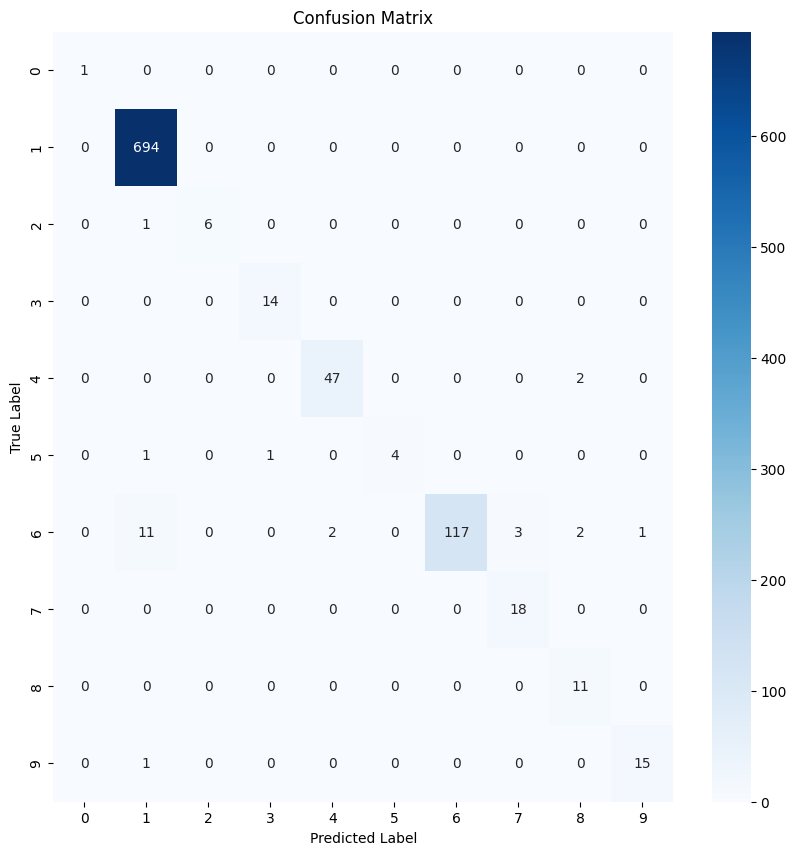

In [121]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [122]:
report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print(report)

                             precision    recall  f1-score   support

          Amylax_triacantha       1.00      1.00      1.00         1
    Aphanizomenon_flosaquae       0.98      1.00      0.99       694
Aphanothece_paralleliformis       1.00      0.86      0.92         7
                      Beads       0.93      1.00      0.97        14
               Centrales_sp       0.96      0.96      0.96        49
      Ceratoneis_closterium       1.00      0.67      0.80         6
             Chaetoceros_sp       1.00      0.86      0.92       136
      Chaetoceros_sp_single       0.86      1.00      0.92        18
             Chlorococcales       0.73      1.00      0.85        11
              Chroococcales       0.94      0.94      0.94        16

                   accuracy                           0.97       952
                  macro avg       0.94      0.93      0.93       952
               weighted avg       0.98      0.97      0.97       952

